# Timeseries

This notebook contains the code used to generate the timeseries image for the climatedt paper.
If you want to just reproduce the figure, jump to the second part of the notebook.

In [1]:
from aqua.diagnostics.timeseries import Timeseries

Let's plot the global mean temperature for the historical experiment, with a comparison done with the same ERA5 time span and 1990-1999 climatology.

In [2]:
models = ['ICON']
exps = ['historical-1990']
sources = ['lra-r100-monthly']
var = '2t'

In [3]:
ts = Timeseries(var=var, models=models, exps=exps, sources=sources,
                std_startdate='1990-01-01', std_enddate='2020-12-01', extend=False,
                loglevel='INFO')

In [ ]:
ts.run()

2025-02-04 16:46:58 :: Timeseries :: INFO     -> Retrieving data for None ICON historical-1990 lra-r100-monthly
2025-02-04 16:46:58 :: ConfigPath :: INFO     -> ICON_historical-1990_lra-r100-monthly triplet found in in climatedt-phase1!
2025-02-04 16:46:59 :: Reader :: INFO     -> Convention dictionary: eccodes-2.39.0
2025-02-04 16:46:59 :: Reader :: INFO     -> Fix names in metadata is icon-destine-v1-lra
2025-02-04 16:46:59 :: Reader :: INFO     -> Fix names icon-destine-v1-lra found in fixes files
2025-02-04 16:46:59 :: Reader :: INFO     -> Grid metadata is lon-lat
2025-02-04 16:46:59 :: Reader :: INFO     -> Retrieving variables: ['2t']
2025-02-04 16:48:19 :: Reader :: INFO     -> Variables to be fixed: {'2t': {'source': [167, 228004, '2t', 'tas', 'mean2t', 'avg_2t', 'T2M'], 'grib': 167}}
2025-02-04 16:48:19 :: Reader :: INFO     -> 2t: converting units K --> K
2025-02-04 16:48:19 :: Reader :: INFO     -> coordinates adjusted to cf by AQUA fixer
2025-02-04 16:48:19 :: Reader :: WA

# Plot of the timeseries

Now we have the data and we can customize the plot function

In [55]:
import xarray as xr
import matplotlib.pyplot as plt
from aqua.logger import log_configure

def plot_paper_timeseries(monthly_data=None,
                          annual_data=None,
                          ref_monthly_data=None,
                          ref_annual_data=None,
                          std_monthly_data=None,
                          std_annual_data=None,
                          data_labels: list = None,
                          ref_label: str = None,
                          loglevel: str = 'WARNING',
                          **kwargs):
    """
    monthly_data and annual_data are list of xr.DataArray
    that are plot as timeseries together with their reference
    data and standard deviation.

    Arguments:
        monthly_data (list of xr.DataArray): monthly data to plot
        annual_data (list of xr.DataArray): annual data to plot
        ref_monthly_data (xr.DataArray): reference monthly data to plot
        ref_annual_data (xr.DataArray): reference annual data to plot
        std_monthly_data (xr.DataArray): standard deviation of the reference monthly data
        std_annual_data (xr.DataArray): standard deviation of the reference annual data
        data_labels (list of str): labels for the data
        ref_label (str): label for the reference data
        loglevel (str): logging level

    Keyword Arguments:
        figsize (tuple): size of the figure
        title (str): title of the plot

    Returns:
        fig, ax (tuple): tuple containing the figure and axis objects
    """
    logger = log_configure(loglevel, 'PlotTimeseries')
    fig_size = kwargs.get('figsize', (10, 5))
    fig, ax = plt.subplots(1, 1, figsize=fig_size)

    color_list = ["#1898e0", "#8bcd45", "#f89e13", "#d24493",
                  "#00b2ed", "#dbe622", "#fb4c27", "#8f57bf",
                  "#00bb62", "#f9c410", "#fb4865", "#645ccc"]

    if monthly_data is not None:
        if isinstance(monthly_data, xr.DataArray):
            monthly_data = [monthly_data]
        for i in range(len(monthly_data)):
            color = color_list[i]
            try:
                mon_data = monthly_data[i]
                label = data_labels[i]
                mon_data.plot(ax=ax, label=label, color=color, lw=2.0)
            except Exception as e:
                logger.debug(f"Error plotting monthly data: {e}")

    if annual_data is not None:
        for i in range(len(annual_data)):
            color = color_list[i]
            try:
                ann_data = annual_data[i]
                label = None
                ann_data.plot(ax=ax, label=label, color=color, linestyle='--', lw=2.0)
            except Exception as e:
                logger.debug(f"Error plotting annual data: {e}")

    if ref_monthly_data is not None:
        try:
            ref_label_mon = ref_label
            ref_monthly_data.plot(ax=ax, label=ref_label_mon, color='black', lw=1.0)
            if std_monthly_data is not None:
                std_monthly_data.compute()
                ax.fill_between(ref_monthly_data.time,
                                ref_monthly_data - 2.*std_monthly_data.sel(month=ref_monthly_data["time.month"]),
                                ref_monthly_data + 2.*std_monthly_data.sel(month=ref_monthly_data["time.month"]),
                                facecolor='grey', alpha=0.25)
        except Exception as e:
            logger.debug(f"Error plotting monthly std data: {e}")

    if ref_annual_data is not None:
        try:
            ref_label_ann = None
            ref_annual_data.plot(ax=ax, label=ref_label_ann, color='black', linestyle='--', lw=1.0)
            if std_annual_data is not None:
                std_annual_data.compute()
                ax.fill_between(ref_annual_data.time,
                                ref_annual_data - 2.*std_annual_data,
                                ref_annual_data + 2.*std_annual_data,
                                facecolor='black', alpha=0.2)
        except Exception as e:
            logger.debug(f"Error plotting annual std data: {e}")

    ax.legend(fontsize='x-large')
    ax.grid(axis="x", color="k")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_xlabel("Year", fontsize=16)
    ax.set_ylabel(mon_data.long_name, fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)

    title = kwargs.get('title', None)
    if title:
        ax.set_title(title, fontsize=20)

    return fig, ax

We open the data produced by the diagnostic as xarray

In [9]:
data_mon = xr.open_dataarray('netcdf/timeseries.timeseries.climatedt-phase1.ICON.historical-1990.2t.frequency_monthly.nc')
data_ann = xr.open_dataarray('netcdf/timeseries.timeseries.climatedt-phase1.ICON.historical-1990.2t.frequency_annual.nc')
obs_mon = xr.open_dataarray('netcdf/timeseries.timeseries.obs.ERA5.era5.2t.frequency_monthly.nc')
obs_ann = xr.open_dataarray('netcdf/timeseries.timeseries.obs.ERA5.era5.2t.frequency_annual.nc')
std_mon = xr.open_dataarray('netcdf/timeseries.timeseries.obs.ERA5.era5.2t.frequency_monthly.stat_std.nc')
std_ann = xr.open_dataarray('netcdf/timeseries.timeseries.obs.ERA5.era5.2t.frequency_annual.stat_std.nc')

In [40]:
data_labels = ['ICON historical 1990']
ref_label = ['ERA5']

title = '2 meter temperature - ICON historical 1990, ERA5 1990-2020'

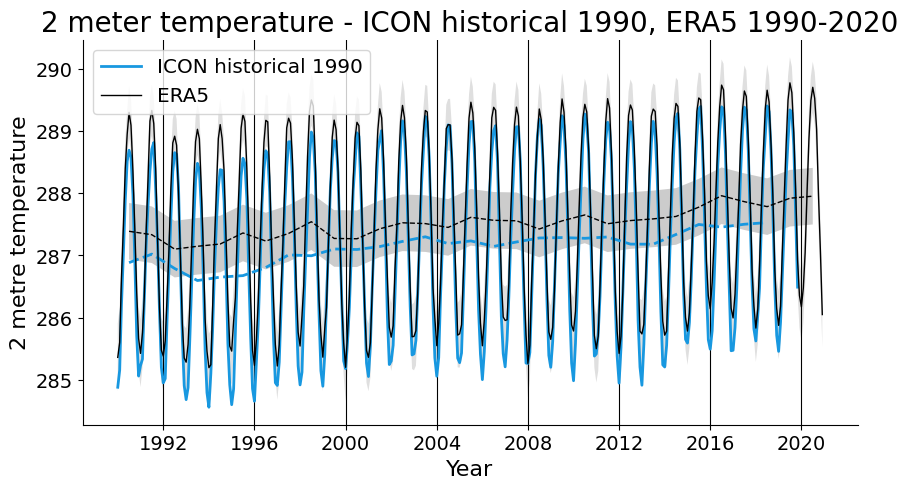

In [56]:
fig, ax = plot_paper_timeseries(monthly_data=[data_mon], annual_data=[data_ann],
                                ref_monthly_data=obs_mon, ref_annual_data=obs_ann,
                                std_monthly_data=std_mon, std_annual_data=std_ann,
                                data_labels=data_labels, ref_label=ref_label,
                                title=title, loglevel='DEBUG')

In [57]:
fig.savefig('timeseries.pdf', bbox_inches='tight')